In [ ]:
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization,Dropout, Conv1D, Conv1DTranspose, MaxPooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import load_model
 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd 
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os #
from google.colab import drive 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


#Определение мошеннических операций

## Имеется база банковских операций, прямое обучение с учителем достаточно плохо будет работать, потому что мошеннических операций в 1000 раз меньше. Использовал автокодировщик, который обучается на легальных операциях, тем самым на них он будет ошибаться меньше, чем на мошеннических Путем вычисления ошибки восстановления при прогоне операции через автокодировщик, вычисляется оптимальный порог ошибки, при котором точность выявления операций станет равной 92%. Данный подход хорош тем, что порог можно занизить для большей надежности, и подозрительные операции отправлять для детальной проверки банковским сотрудникам.


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Базы/creditcard.csv") 

##Предобработка данных


In [ ]:
df.head() # выводим первые пять строк

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Удаляем столбец со временем
data = df.drop(['Time'], axis=1)
# Нормализуем столбец с суммой транзакции
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

frauds = data[data.Class == 1] # записываем мошеннические операции
normal = data[data.Class == 0] # записываем нормальные операции

In [ ]:
normal.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [ ]:
frauds.shape # смотрим какие размеры у мошеннических операций

(492, 30)

In [ ]:
normal.shape # смотрим какие размеры у нормальных операций

(284315, 30)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение

# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.2, shuffle = True, random_state=RANDOM_SEED)

In [ ]:
# Удаляем класс в обучающем наборе данных
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values



# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = pd.concat([X_test, frauds])
# Делаем метки для тестового набора данных
y_test = X_test['Class']
# Удаляем класс у тестового набора данных
X_test = X_test.drop(['Class'], axis=1)
# Преобразуем данные в массивы numpy

X_test = X_test.values


In [ ]:
print(X_train.shape) # взглянем на размеры обучающих данных

(227452, 29)


In [ ]:
print(X_test.shape)

(57355, 29)


##Автокодировщик

Важно не переборщиить со сложностью автокодировщика, чтобы он выделял важные моменты , обобщал, не переобучался.

In [ ]:
def creditcardAutoencoder(): 
  dataSize = X_train.shape[1]
  dataInput = Input(shape=(dataSize, ))
  #x = Dense(100, activation = 'relu')(dataInput)

  #x = Dropout(0.2)(x)
  
  x = Dense(10, activation='relu')(dataInput)

  #x = Dense(100, activation = 'relu')(z)
  #x = Dropout(0.2)(x)

  x = Dense(dataSize, activation='linear')(x) 
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer='Adam', loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 


model = creditcardAutoencoder()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                319       
Total params: 619
Trainable params: 619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.compile(optimizer=Adam(lr=1e-4), loss='mse')
best__loss = ModelCheckpoint('best_loss.h5', save_best_only=True, monitor='loss', mode='min')
history = model.fit(X_train, X_train,
                    epochs=25,
                    batch_size=32,
                    
                    callbacks = [best__loss])

Epoch 1/25
7108/7108 [==============================] - 14s 2ms/step - loss: 0.5872
Epoch 2/25
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3633
Epoch 3/25
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3601
Epoch 4/25
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3584
Epoch 5/25
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3531
Epoch 6/25
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3515
Epoch 7/25
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3573
Epoch 8/25
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3519
Epoch 9/25
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3551
Epoch 10/25
7108/7108 [==============================] - 12s 2ms/step - loss: 0.3544
Epoch 11/25
7108/7108 [==============================] - 11s 2ms/step - loss: 0.3526
Epoch 12/25
7108/7108 [==============================] - 12s 2ms/step - lo

In [ ]:
model_best = load_model('/content/best_loss.h5')

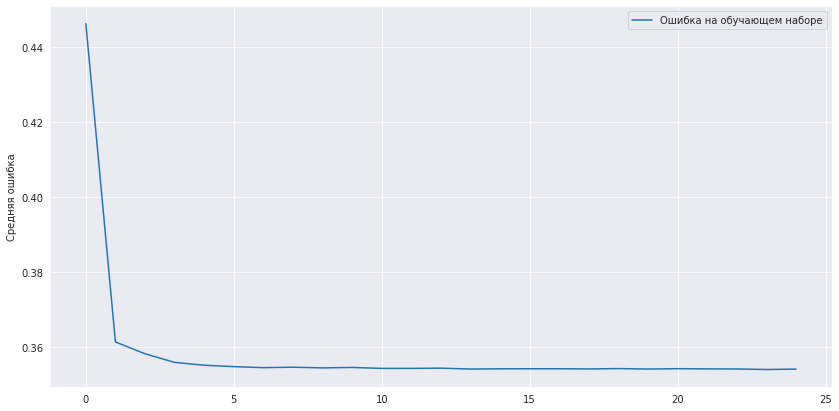

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
predictions = model_best.predict(X_test) # делаем предсказание по X_test
mse = np.mean(np.power(X_test - predictions, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test
mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

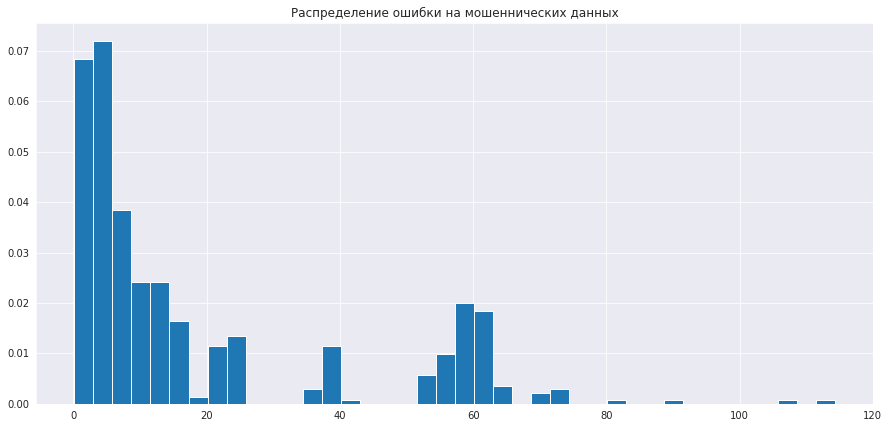

In [ ]:
plt.figure(figsize = (15,7))
plt.hist(mse_frauds, density=True, bins=40)
plt.title('Распределение ошибки на мошеннических данных')
plt.ylabel('')
plt.show()

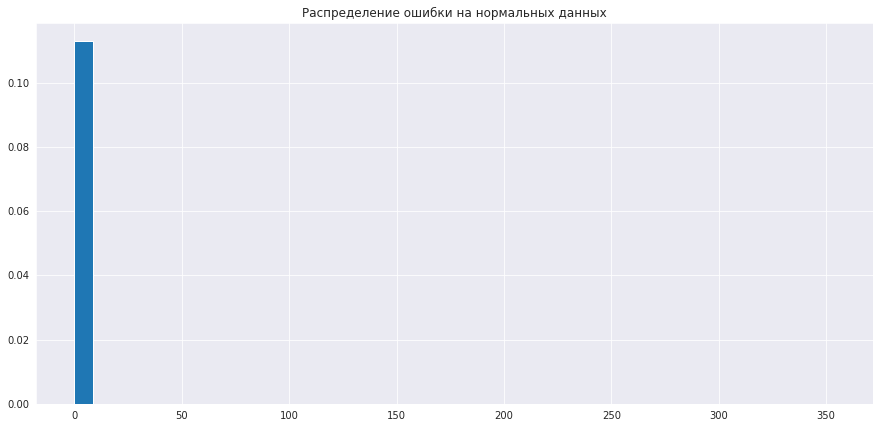

In [ ]:
plt.figure(figsize = (15,7))
plt.hist(mse_normal, density=True, bins=40)
plt.title('Распределение ошибки на нормальных данных')
plt.show()

In [ ]:
print(pd.Series(mse_frauds).describe())
print(pd.Series(mse_normal).describe())

count    492.000000
mean      19.107532
std       22.459855
min        0.159839
25%        3.989410
50%        8.606871
75%       24.447726
max      114.361378
dtype: float64
count    56863.000000
mean         0.354407
std          1.600061
min          0.039622
25%          0.165767
50%          0.242928
75%          0.385550
max        326.427319
dtype: float64


In [ ]:
print("Минимальная ошибка нормальных транзакций:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных транзакций:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

print("Минимальная ошибка мошеннических транзакций:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических транзакций:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка нормальных транзакций: 0.0396
Максимальная ошибка нормальных транзакций: 326.4273
Средняя ошибка нормальных транзакций: 0.3544
Минимальная ошибка мошеннических транзакций: 0.1598
Максимальная ошибка мошеннических транзакций: 114.3614
Средняя ошибка мошеннических транзакций: 19.1075


##Нужно по графику понять, определить следующие границы. Но по данному графику это сложно сделать, поэтому написал функцию.

Постройте на одном графике 2 гистограммы (density=True) для нормальных и мошеннических транзакций. По графику определите 3 порога:
1) при котором все мошеннические транзакции будут пойманы
2) “оптимальный порог” - на пересечении распределений
3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая

In [ ]:
#Функция принимает 2 массива ошибок, 1 массив на валидные операции, второй массив - мошенники. ВОзвращает 3 числа.
#1 - порог по поиску ВСЕХ мошенников. 2 - Порог по поиску ВСЕХ нормальных транзакций 3 - Оптимальный Порог

def porog(x,y,k=1):
    #x - Валидные операции
    #y - Мошенники
    valids = x.max()
    targets = y.min()
    optimal = np.quantile(x, 0.5) +  k*x.std() #95% доверительный интервал для валидных
    result = {'targets': targets, 'valids':valids, 'optimal':optimal}
    return result

def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций
  return (accNormal, accFaruds)

result = porog(mse_normal, mse_frauds,0.5)
print(result)
for i in result:
    print('----------------Результат при ', i, '--------------------')
    t = getAccByBias(result[i])
    print("Распознано нормальных транзакций: ", round(100*t[0]), "%", sep="")
    print("Распознано мошеннических транзакций: ", round(100*t[1]), "%", sep="")
    print("Средняя точность распознавания: ", round(50*(t[0] + t[1])), "%", sep="")
    

{'targets': 0.15799456738057524, 'valids': 354.2357903738266, 'optimal': 1.0998822512720965}
----------------Результат при  targets --------------------
Распознано нормальных транзакций: 22%
Распознано мошеннических транзакций: 100%
Средняя точность распознавания: 61%
----------------Результат при  valids --------------------
Распознано нормальных транзакций: 100%
Распознано мошеннических транзакций: 0%
Средняя точность распознавания: 50%
----------------Результат при  optimal --------------------
Распознано нормальных транзакций: 98%
Распознано мошеннических транзакций: 86%
Средняя точность распознавания: 92%


##Теперь подберем оптимальный параметр отклонения порога отмедианы, чтобы точность была не менее 92%

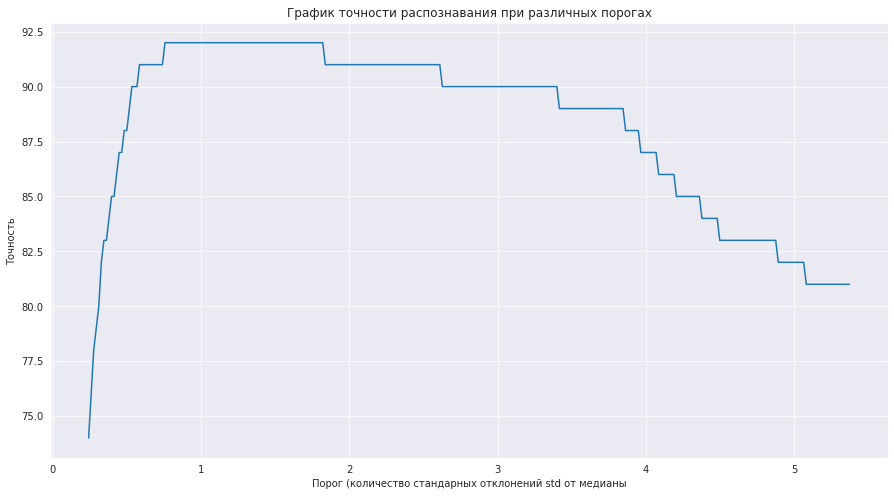

In [ ]:
r=[]
v = []
for i in np.arange(0,3,0.01):
  result = porog(mse_normal, mse_frauds,i)
  v.append(result['optimal'])
  t = getAccByBias(result['optimal'])
  r.append(round(50*(t[0] + t[1])))
r = np.array(r)
v = np.array(v)
plt.figure(figsize = (15,8))
plt.plot(v,r)
plt.xlabel('Порог (количество стандарных отклонений std от медианы')
plt.ylabel('Точность')
plt.title('График точности распознавания при различных порогах')
plt.show()

#Порог - это количество стандартных отклонений от медианы. На графике при пороге  в районе 1 std точность достигает 92%

In [ ]:
#Максимальная точность
r.max()

92

#При Оптимальном распознавании 92% мошеннических  операций распознано в пике. Порог равен медиана + std распределения нормальных операций. Задание выполнено

# Требовалось построить 2 распределения на 1 графике:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


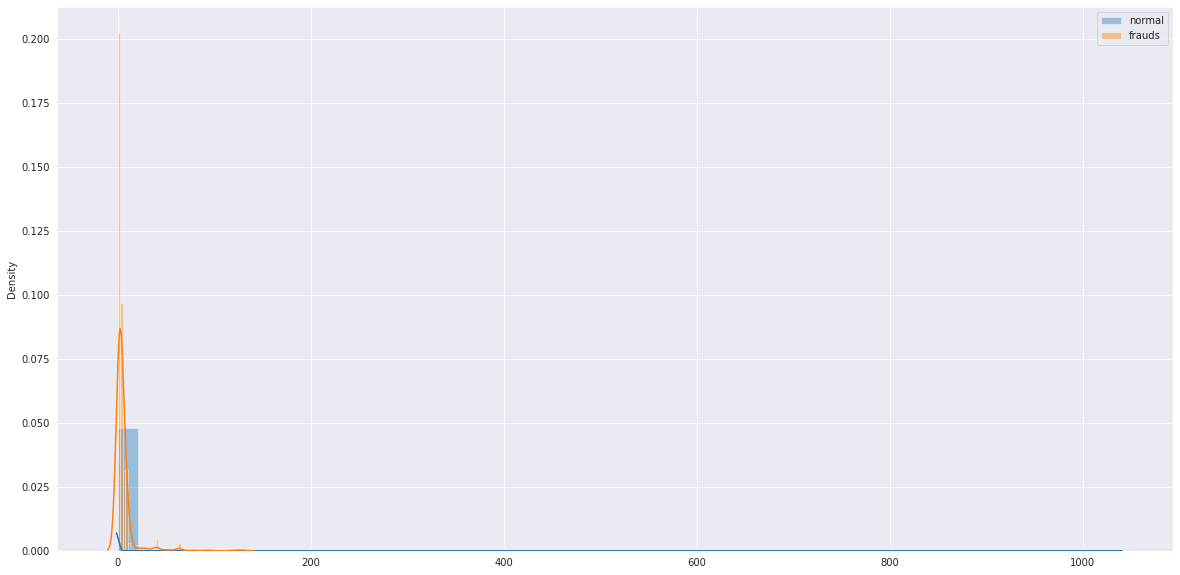

In [ ]:
plt.figure(figsize = (20,10))
sns.distplot(mse_normal, label = 'normal')
sns.distplot(mse_frauds, label = 'frauds')
plt.legend()
plt.show()